In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
np.random.seed(0) # for reproducibility
import sklearn

Here model will work with a star catalogue of 240 stars described by the following information:
1. Temperature (in Kelvin)
2. Luminosity (L/Lo)
3. Radius (R/Ro)
4. Absolute magnitude (Mv)

#Loading and preprocessing of the data

In [2]:
df_stars = pd.read_csv("stars.csv")

In [3]:
df_stars.head()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,3068,0.002400,0.1700,16.12,Brown Dwarf,Red,M
1,3042,0.000500,0.1542,16.60,Brown Dwarf,Red,M
2,2600,0.000300,0.1020,18.70,Brown Dwarf,Red,M
3,2800,0.000200,0.1600,16.65,Brown Dwarf,Red,M
4,1939,0.000138,0.1030,20.06,Brown Dwarf,Red,M


There are 6 star types that are encoded in the 'Star type' column.

In [4]:
from sklearn.preprocessing import LabelEncoder #to convert a set of values to integers
lbl_ncdr=LabelEncoder()


#assign unique integers from 0 to 6 to each star type
df_stars['Star type']=lbl_ncdr.fit_transform(df_stars['Star type']) #fit and transform Star type data in labelEncoder
class_names=lbl_ncdr.classes_
print(class_names)

['Brown Dwarf' 'Hypergiant' 'Main Sequence' 'Red Dwarf' 'Supergiant'
 'White Dwarf']


In [5]:
lbl=lbl_ncdr.inverse_transform(df_stars['Star type'])

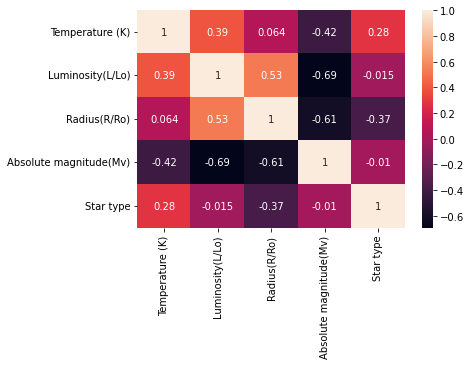

In [6]:
#checking if any missing values or NaNs in data or is data skewed or 2somehow correlation between variables
sns.heatmap(df_stars.corr(),annot=True)
plt.show() #displaying the correlated heatmap 

The star type is not correlated with any particular column from the catalogue. Star classification is something that can be done based on rules depending on temperature and luminosity. For example, Wikipedia gives the following example of a Hertzsprung-Russell diagram:


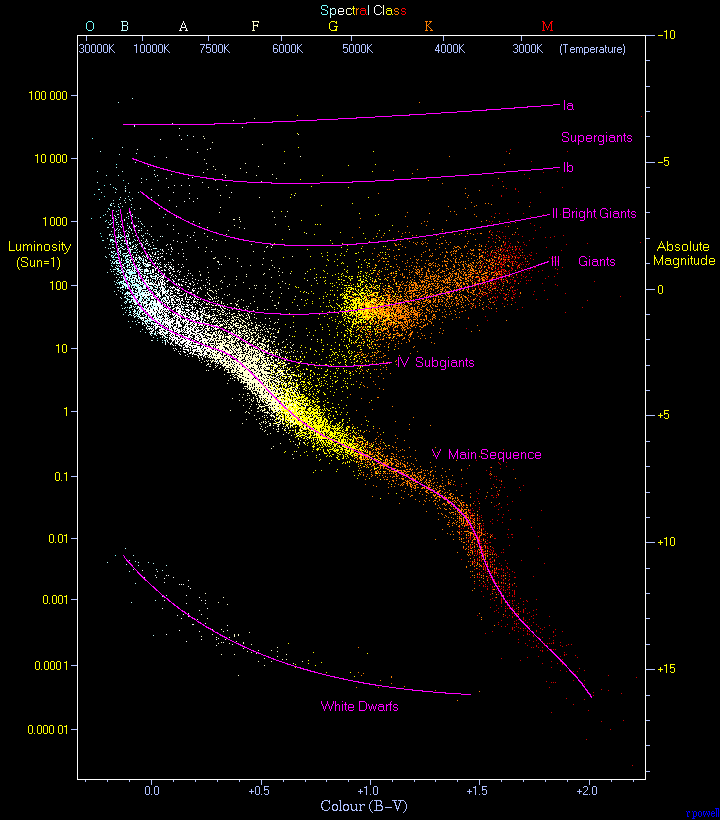

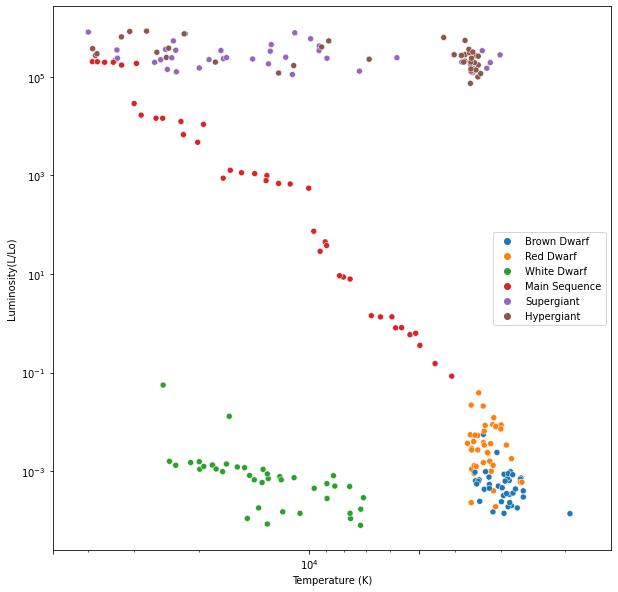

In [7]:
fig=plt.figure(figsize=(10,10)) #fixing the figure size
sns.scatterplot(data=df_stars,x="Temperature (K)",y="Luminosity(L/Lo)",hue=lbl)
plt.xscale("log") #taking the values in the log form(since stars distance can't be measured in normal values)
plt.yscale("log")
plt.xticks([5000,10000,50000])
plt.xlim(5e4,1.5e3)#setting limits for x and y axis
plt.show()

Main Sequence stars and White Dwarves are fairly easy to isolate from the rest: a statistical model should be able to easily classify them. Based only on Luminosity and Temperature, Dwarf stars and Giant stars have higher intra-group variability: Supergiant and Hypergiant cover the same space (same for Brown and Red Dwarves).

In [8]:
from sklearn.decomposition import PCA #Principal Component Analysis #to reduce number of features in data
#PCA finds linear combinations of variables that explain most of the variance in the data.
pca=PCA(n_components=2)

In [9]:
df_stars_data=df_stars.drop(columns=["Star color","Star type","Spectral Class"]) #drop the following columns
X=np.array(df_stars_data) 

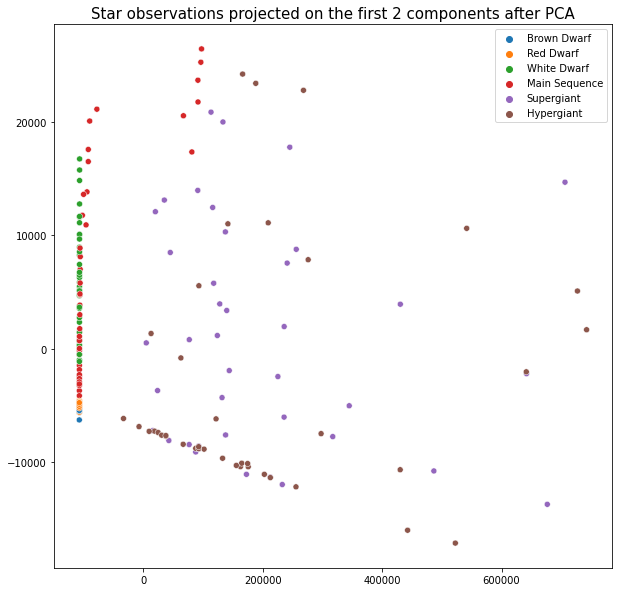

In [10]:
#apply PCA to project our data in 2D space that maximizes variable i.e. dimension reduction
projected_stars=pca.fit_transform(X)
fig=plt.figure(figsize=(10,10))
sns.scatterplot(x=projected_stars[:,0],y=projected_stars[:,1],hue=lbl)
plt.title("Star observations projected on the first 2 components after PCA",fontsize=15)
plt.show()

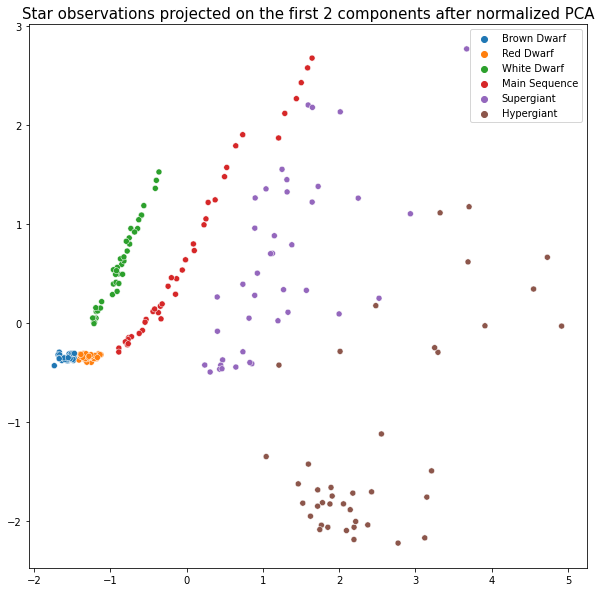

In [11]:
#scaler to center (mean=0) and normalize (std=1) the data
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X=scaler.fit_transform(df_stars_data)

pca=PCA()
projected_stars=pca.fit_transform(X)

fig=plt.figure(figsize=(10,10))
sns.scatterplot(x=projected_stars[:,0],y=projected_stars[:,1],hue=lbl)
plt.title("Star observations projected on the first 2 components after normalized PCA",fontsize=15)
plt.show()

For linear models, rescaling is required when dealing with values expressed in different units. PCA finds the linear combinations that explain most of the variance.

In [12]:
s=0
for idx, r in enumerate(pca.explained_variance_ratio_):#to check how much information we lost by keeping the first two components
    s+=r
    print(f"Component {idx+1} explains {100*r:.1f}% of the variance (cumulative ={100*r:.1f})")

Component 1 explains 60.4% of the variance (cumulative =60.4)
Component 2 explains 23.5% of the variance (cumulative =23.5)
Component 3 explains 9.3% of the variance (cumulative =9.3)
Component 4 explains 6.8% of the variance (cumulative =6.8)


The projection on 2D plane explains 84% of variance of dataset. Thus the visualization does not hide too much information so it gives faithful depiction of dataset

#Model Selection: train/test split

In [13]:
from sklearn.model_selection import train_test_split
stars_train, stars_test=train_test_split(df_stars.drop(columns=["Star color", "Spectral Class"]),train_size=0.2) #splitting test and train set

In [14]:
X_train, y_train=stars_train.drop(columns="Star type"),stars_train["Star type"] #drop Star type column in train set
X_test, y_test=stars_test.drop(columns="Star type"),stars_test["Star type"] #drop Star type column in test set

#Decision Tree

In [15]:
from sklearn.tree import DecisionTreeClassifier
tree=DecisionTreeClassifier()

In [16]:
tree.fit(X_train,y_train) #training the Decision Tree model

DecisionTreeClassifier()

In [17]:
tree.predict(X_test) #checking the accuracy on the test data

array([4, 3, 2, 3, 4, 4, 2, 4, 2, 3, 0, 5, 5, 2, 1, 3, 3, 1, 4, 0, 2, 1,
       5, 3, 0, 5, 3, 2, 3, 4, 1, 4, 5, 3, 5, 1, 5, 1, 0, 3, 2, 4, 2, 3,
       4, 3, 2, 0, 1, 1, 0, 2, 1, 3, 2, 2, 1, 2, 1, 4, 3, 2, 2, 1, 5, 2,
       0, 2, 0, 3, 0, 4, 3, 2, 1, 3, 5, 1, 4, 2, 4, 3, 0, 4, 5, 2, 2, 3,
       1, 3, 3, 3, 1, 4, 1, 3, 5, 1, 1, 0, 3, 5, 0, 3, 4, 3, 4, 0, 5, 1,
       2, 5, 2, 4, 0, 1, 3, 5, 3, 5, 0, 1, 5, 4, 3, 3, 3, 3, 3, 1, 1, 2,
       2, 2, 4, 4, 1, 3, 2, 2, 0, 4, 4, 5, 1, 5, 5, 5, 0, 2, 3, 5, 1, 0,
       0, 5, 3, 4, 0, 5, 3, 3, 3, 5, 3, 1, 4, 2, 1, 3, 3, 3, 3, 4, 4, 3,
       5, 3, 2, 3, 1, 4, 3, 0, 2, 5, 3, 1, 4, 2, 2, 3])

In [18]:
tree.score(X_test, y_test) #loop on all test samples to check whether prediction matches the expected label

0.8489583333333334

The Model reached over 90% accuracy on test size

#Confusion Matrix

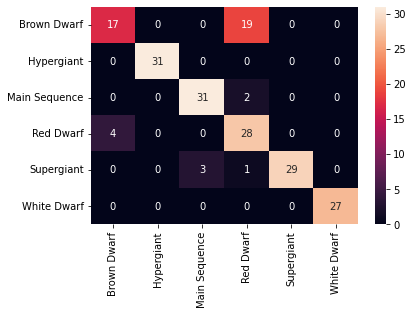

In [19]:
from sklearn.metrics import confusion_matrix #indicates for each actual star type (rows) how the stars of this group have been predicted (columns)

y_pred=tree.predict(X_test)
cm=confusion_matrix(y_test,y_pred)
sns.heatmap(cm, annot=True, xticklabels=class_names, yticklabels=class_names) #annot to write data values in cell
plt.show()

We can see that the 35 brown dwarves of the test dataset have all been correctly predicted as brown dwarves. However, 8 stars from the Main Sequence have been classified as Red Dwarfs.

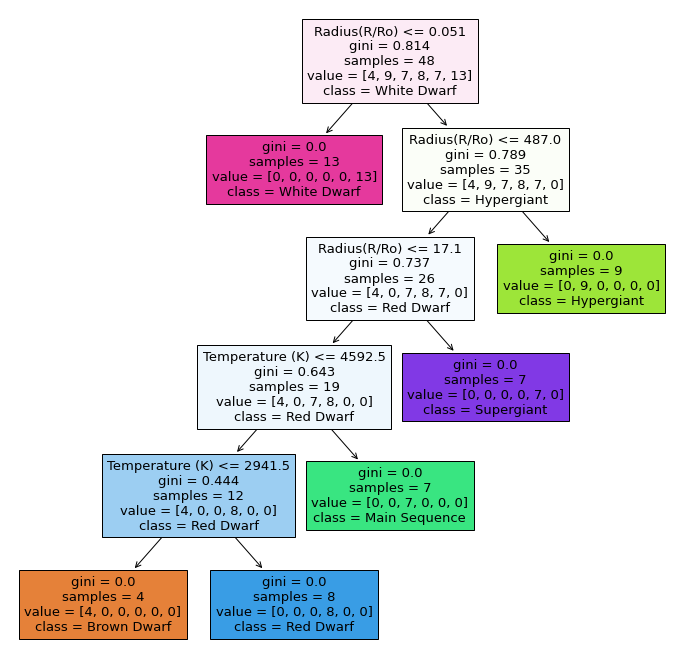

In [20]:
fig=plt.figure(figsize=(12,12))
sklearn.tree.plot_tree(tree, filled=True, feature_names=stars_train.drop(columns="Star type").keys(),class_names=class_names)
plt.show()

Not all models have same interface so we can just swap decision tree with a SVC (Support Vector Classifier)

#SVM

In [21]:
from sklearn.svm import SVC
scaler2 = StandardScaler()
X_train_s = scaler2.fit_transform(X_train)
X_test_s = scaler2.transform(X_test)
svm = SVC()
svm.fit(X_train_s, y_train)
svm.score(X_test_s, y_test)

0.765625

In [22]:
svm = SVC(C=100, kernel='poly', degree=4) #SVM with a polynomial kernel of degree 4 and C=100
svm.fit(X_train_s, y_train)
svm.score(X_test_s, y_test)

0.9375

In [23]:
#importing the warning library to avoid red warning pop-ups
import warnings
warnings.filterwarnings("ignore")

To avoid overfitting the test set, we will do cross-validation for each combination. scikit-learn conveniently offers a tool called GridSearchCV to this end and its interface is the same as all the other models!

In [24]:
from sklearn.model_selection import GridSearchCV #model_selection package

grid = {'C': [1e-2, 0.1, 1.0, 10, 100, 1000, 10000], 'kernel': ['linear', 'rbf'], 'gamma': ['auto', 'scale']}
model = GridSearchCV(SVC(), grid)
model.fit(X_train_s, y_train)
model.score(X_test_s, y_test)

1.0

In [25]:
model.best_params_ #hyperparameters for the model used

{'C': 10, 'gamma': 'auto', 'kernel': 'linear'}

We can see that SVM performs the same as our decision tree even a little better

#Data Mining for large collections of image

In [26]:
import urllib.request
urllib.request.urlretrieve("http://astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5", "Galaxy10.h5")

('Galaxy10.h5', <http.client.HTTPMessage at 0x7f04b046e9d0>)

In [27]:
import numpy as np
import h5py
#file_name="Galaxy10 (1).h5" #use if using jupyter notebook and can deduce above cell
open_mode='r'
# Images and labels are stored in HDF5 format but we could use flat files instead
with h5py.File("Galaxy10.h5", open_mode) as F: # reading the h5py file as F
    images = np.array(F['images'])
    labels = np.array(F['ans'], dtype='int64')

print(f"Galaxy10 dataset: {len(images)} images and {len(np.unique(labels))} classes")

Galaxy10 dataset: 21785 images and 10 classes


The goal of the Galaxy10 dataset is perform classification of these images into one of the 10 galaxy shapes defined hereafter

In [28]:
class_names = [ #specifing the galaxies as classes
    "Disk, Face-on, No Spiral",
    "Smooth, Completely round",
    "Smooth, in-between round",
    "Smooth, Cigar shaped",
    "Disk, Edge-on, Rounded Bulge",
    "Disk, Edge-on, Boxy Bulge",
    "Disk, Edge-on, No Bulge",
    "Disk, Face-on, Tight Spiral",
    "Disk, Face-on, Medium Spiral",
    "Disk, Face-on, Loose Spiral"
]

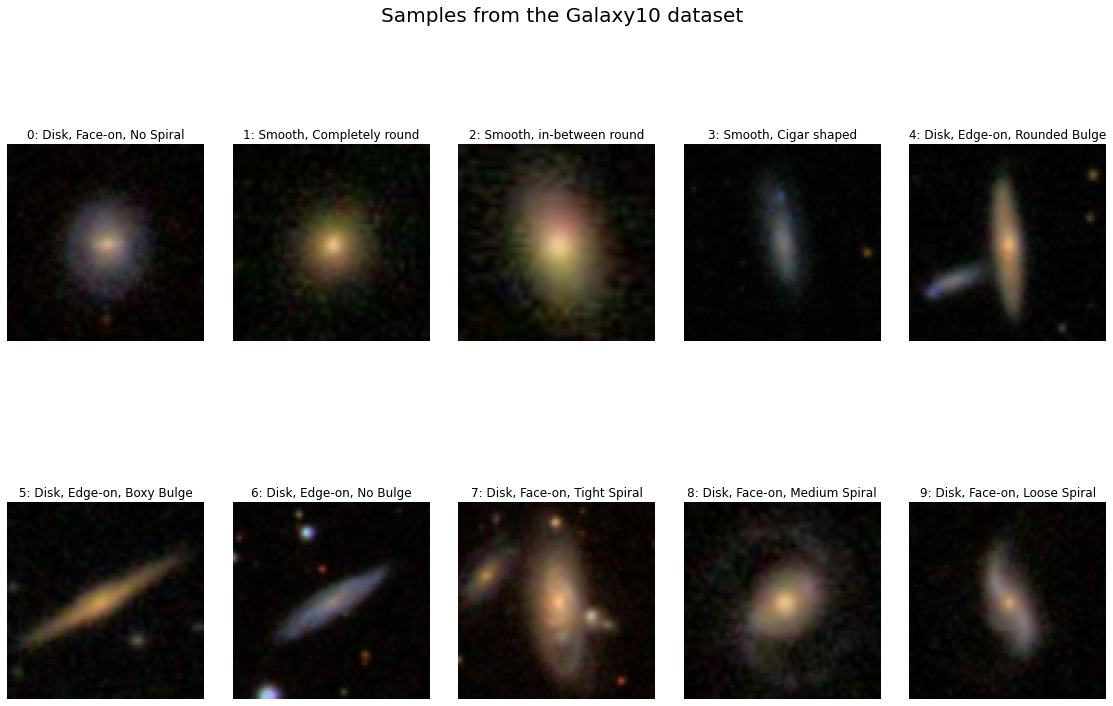

In [29]:
_, demo_idx = np.unique(labels, return_index=True)

fig = plt.figure(figsize=(16, 12))
for idx, (img, label) in enumerate(zip(images[demo_idx], labels[demo_idx])): #loop to plot all the galaxies images once
    fig.add_subplot(2, 5, idx+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{label}: {class_names[label]}")
fig.tight_layout(h_pad=0, w_pad=0)
plt.suptitle("Samples from the Galaxy10 dataset", fontsize=20)
plt.show()

We will split the dataset in two and will use 60% of the images for training and the remaining 40% for test.

In [30]:
images_train, images_test, y_train, y_test = train_test_split(images.astype('float32'), labels, train_size=0.6)

Using the standard approach for object recognition with images,feature descriptors to describe some properties of the image in a compressed vector with a smaller dimension than the full image matrix.

Performing HOG+SVM comprised of two steps: 1. extract HOG from all images (this produces a 1D feature vector for all images) 2. train a SVM on the HOG features

Histogram of Oriented Gradients (HOG) is a classical feature descriptor for images used in computer vision for object detection and classification. Here idea is that the image will be divided in blocks. On each block, gradients will be computed for different orientations.

In [31]:
from skimage.feature import hog
from tqdm.notebook import tqdm

def hog_galaxy10(image):
    # Compute the Histogram of Oriented Gradients on an image
    # We use 8 orientations and 8 pixels in a cell/block
    return hog(image, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(1,1), multichannel=True)

# Extract HOG on the training and testing images.
# This will take a few seconds.
X_train = np.array([hog_galaxy10(image) for image in tqdm(images_train, desc="HOG on train")], dtype='float32')
X_test = np.array([hog_galaxy10(image) for image in tqdm(images_test, desc="HOG on test")], dtype='float32')

HOG on train:   0%|          | 0/13071 [00:00<?, ?it/s]

HOG on test:   0%|          | 0/8714 [00:00<?, ?it/s]

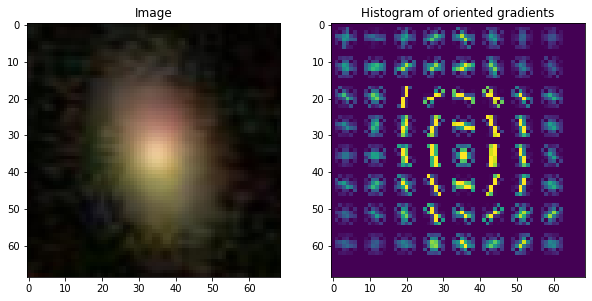

In [32]:
from skimage import data, exposure

feat, hog_image = hog(images[0], orientations=8, pixels_per_cell=(8, 8), cells_per_block=(1,1), multichannel=True, visualize=True)

fig = plt.figure(figsize=(10, 10))
fig.add_subplot(121)
plt.imshow(images[0])
plt.title("Image")
fig.add_subplot(122)
hog_image = exposure.rescale_intensity(hog_image, in_range=(0, 10))
plt.imshow(hog_image)
plt.title("Histogram of oriented gradients")
plt.show()

In [33]:
from sklearn.svm import LinearSVC

svm = LinearSVC(max_iter=2000)
svm.fit(X_train, y_train)
svm.score(X_test, y_test)

0.6082166628414046

#HOG + Neural Networks

In [34]:
! [ ! -z "$COLAB_GPU" ] && pip install torch torchvision pillow==4.1.1 skorch
! [ ! -z "$COLAB_GPU" ] && mkdir -p datasets
! [ ! -z "$COLAB_GPU" ] && wget -nc --no-check-certificate https://download.pytorch.org/tutorial/hymenoptera_data.zip -P datasets
! [ ! -z "$COLAB_GPU" ] && unzip -u datasets/hymenoptera_data.zip -d datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.3 MB 14.9 MB/s 
     |████████████████████████████████| 155 kB 68.2 MB/s 
     |████████████████████████████████| 112 kB 71.8 MB/s 
     |████████████████████████████████| 19.1 MB 1.2 MB/s 
     |████████████████████████████████| 19.1 MB 343 kB/s 
     |████████████████████████████████| 776.3 MB 19 kB/s 
     |████████████████████████████████| 21.0 MB 5.7 MB/s 
     |████████████████████████████████| 750.6 MB 12 kB/s 
     |████████████████████████████████| 23.2 MB 1.2 MB/s 
     |████████████████████████████████| 23.3 MB 86.9 MB/s 
     |██████████████████████████████▎ | 834.1 MB 1.2 MB/s eta 0:00:39tcmalloc: large alloc 1147494400 bytes == 0x37b0000 @  0x7f9184d57615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 

In [35]:
import torch # to simplify the creation of artificial neural network
import skorch #to use PyTorch with sklearn by providing a wrapper
# For reproducibility to use PyTorch with sklearnpurposes, we set the random number generator seed manually.
torch.manual_seed(0)

In [36]:
 # Check if GPU is available to reduce the compute time, fallback on CPU if not 
device = 'cuda' if torch.cuda.is_available else 'cpu'

The output of a neuron is the sum of its weighted inputs passed through an non-linear activation function. SO here we will add non-linearities between the layers. Defining the non-linear MultiLayer Perceptron (MLP) to define a neural network using the Sequential API

In [37]:
from torch import nn
# building the neural networks for multilayer perceptron
mlp = nn.Sequential(
    nn.Linear(512, 1024),
    nn.ReLU(),
    nn.Linear(1024, 1024),
    nn.ReLU(),
    nn.Linear(1024, 1024),
    nn.ReLU(),
    nn.Linear(1024, 10)
)

In [38]:
nn_classifier = skorch.classifier.NeuralNetClassifier(mlp,
                                                      lr=0.05, # Learning rate
                                                      max_epochs=50, # Number of epochs
                                                      criterion=nn.CrossEntropyLoss, # Loss function
                                                      device=device) # Execute on GPU or CPU

Some Hyperparameters to skorch:

1. the loss function that we want to minimize. In our case, we use the cross entropy loss which is the most common for classification.
2. the learning rate, which defines the amplitude of the step in the gradient descent training algorithm.
3. the max_epochs parameters which defines how long the network will be trained. With max_epochs=20, the model will see every sample in the training dataset 20 times.

In [39]:
nn_classifier.fit(X_train, y_train)
nn_classifier.score(X_test, y_test)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.8375       0.3201        1.7241  0.2891
      2        1.7118       0.3201        1.6921  0.2833
      3        1.6667       0.3201        1.6254  0.2634
      4        1.5823       0.3920        1.5332  0.2548
      5        1.5070       0.3430        1.5369  0.2543
      6        1.4793       0.3338        1.5932  0.2578
      7        1.4562       0.4597        1.3815  0.2410
      8        1.4440       0.4669        1.3571  0.2583
      9        1.4238       0.4623        1.3379  0.2435
     10        1.4005       0.4673        1.3228  0.2565
     11        1.3838       0.4566        1.3259  0.3609
     12        1.3598       0.4597        1.3277  0.3879
     13        1.3348       0.4742        1.3185  0.4291
     14        1.3092       0.4883        1.3011  0.4403
     15        1.2827       0.5052        1.2712  0.4702
     16        1.2540       0.5

0.6997934358503557

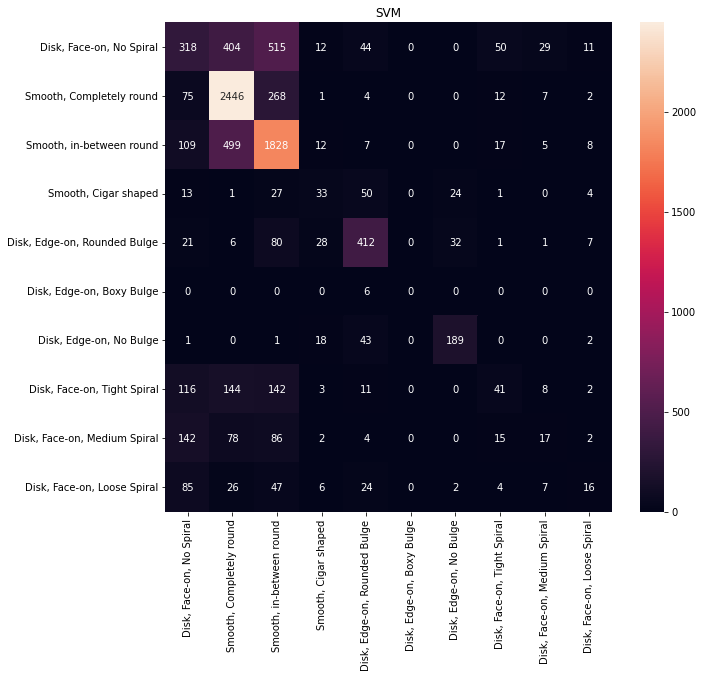

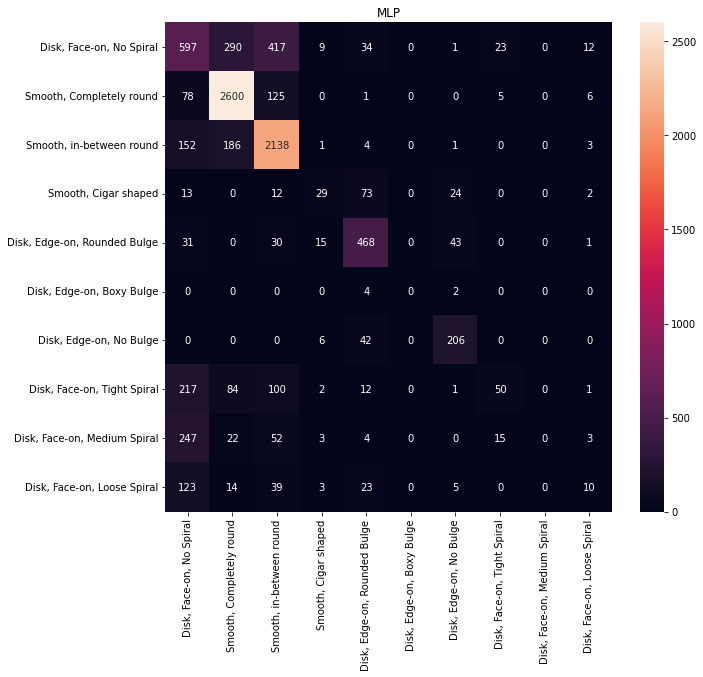

In [40]:
#plotting both confusion matrices to compare the models
def show_G10_results(y_pred, y_test, title=None):
    cm = sklearn.metrics.confusion_matrix(y_test, y_pred)
    fig = plt.figure(figsize=(10, 9))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names )
    if title is not None:
        plt.title(title)
    plt.show()

show_G10_results(svm.predict(X_test), y_test, title="SVM")
show_G10_results(nn_classifier.predict(X_test), y_test, title="MLP")

#CNN (Convolutional neural networks)

(Using for image classification). Convolutional kernels can be shared and used for all pixels in the image. We can perform multiple convolutions on the image to obtain various filtering results. Then, we will apply a non-linear activation (same as in the MLP) and stack a new set of convolutions.

In [41]:
#First, we transpose the image from the HxWxC format (channels last) to the CxHxW format (channels first). 
images_train = images_train.transpose(0, 3, 1, 2)
images_test = images_test.transpose(0, 3, 1, 2)

In [42]:
cnn = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=(3,3), padding=1),
    nn.MaxPool2d(kernel_size=(2, 2)),
    nn.ReLU(),
    nn.Conv2d(64, 128, kernel_size=(3,3), padding=1),
    nn.MaxPool2d(kernel_size=(2, 2)),
    nn.ReLU(),
    nn.Conv2d(128, 256, kernel_size=(3,3), padding=1),
    nn.MaxPool2d(kernel_size=(2, 2)),
    nn.ReLU(),
    nn.Conv2d(256, 256, kernel_size=(3,3), padding=1),
    nn.MaxPool2d(kernel_size=(2, 2)),
    nn.ReLU(),
    nn.Conv2d(256, 256, kernel_size=(3,3), padding=1),
    nn.AdaptiveAvgPool2d((1,1)),
    nn.Flatten(),
    nn.Linear(256, 10)
)

cnn_classifier = skorch.classifier.NeuralNetClassifier(cnn,
                                                       lr=0.005,
                                                       optimizer__momentum=0.9,
                                                       max_epochs=20,
                                                       criterion=nn.CrossEntropyLoss,
                                                       device=device)
cnn_classifier.fit(images_train, y_train)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.7781       0.3591        1.5528  4.3190
      2        1.5571       0.3610        1.5093  4.6208
      3        1.4181       0.4302        1.3672  4.7287
      4        1.2954       0.4845        1.2809  4.7479
      5        1.2317       0.5277        1.2355  5.0295
      6        1.1237       0.5488        1.1915  4.9637
      7        1.0042       0.5935        1.0066  4.3122
      8        0.8851       0.6665        0.9188  4.3021
      9        0.7925       0.7151        0.8630  4.3136
     10        0.7391       0.7151        0.8315  4.3296
     11        0.7053       0.6964        0.7918  4.3396
     12        0.6850       0.7426        0.7197  4.3571
     13        0.6339       0.7744        0.6595  4.3657
     14        0.5932       0.7576        0.6954  4.3761
     15        0.6003       0.7235        0.8124  4.3999
     16        0.5652       0.7

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (8): ReLU()
    (9): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): AdaptiveAvgPool2d(output_size=(1, 1))
    (14): Flatten(start_dim=1, end_dim=-1)
 

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


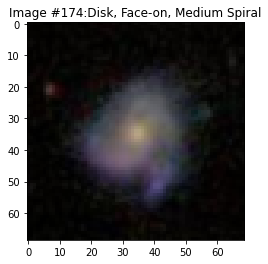

Input image tensor has dimension torch.Size([1, 3, 69, 69])
The output is a vector of size torch.Size([1, 10])
tensor([[ 6.3111, -7.2554, -1.5782, -4.2872, -3.0672, -2.7798, -3.3396,  6.3331,
          7.6641,  5.7383]], device='cuda:0')


In [44]:
#forward propagation
idx = 174
img = images_test[idx]
label = y_test[idx]

plt.imshow(img.astype('uint8').transpose((1,2,0)))
plt.title(f"Image #{idx}:{class_names[label]}")
plt.show()

img_tensor=torch.from_numpy(img).unsqueeze(0) #adding 4th dimension along first axis
print(f"Input image tensor has dimension {img_tensor.size()}")
with torch.no_grad(): #This deactivates the gradient computation (runs faster)
    output = cnn(img_tensor.to(device))
print(f"The output is a vector of size {output.size()}")
print(output)

In [45]:
#get the ranked classes based on their activation 
class_idx = torch.argmax(output[0]) # to get the index of the class predicted by the model
print(f"Predicted class is: {class_idx} ({class_names[class_idx]})")
sorted_classes = np.argsort(-output[0].cpu().numpy()) # argsort by decreasing value
print(f"Other predictions were {[class_names[c] for c in sorted_classes]}")

Predicted class is: 8 (Disk, Face-on, Medium Spiral)
Other predictions were ['Disk, Face-on, Medium Spiral', 'Disk, Face-on, Tight Spiral', 'Disk, Face-on, No Spiral', 'Disk, Face-on, Loose Spiral', 'Smooth, in-between round', 'Disk, Edge-on, Boxy Bulge', 'Disk, Edge-on, Rounded Bulge', 'Disk, Edge-on, No Bulge', 'Smooth, Cigar shaped', 'Smooth, Completely round']


In [46]:
accuracy = cnn_classifier.score(images_test, y_test)
print(f"CNN accuracy is {100*accuracy:.2f}%")

CNN accuracy is 75.95%


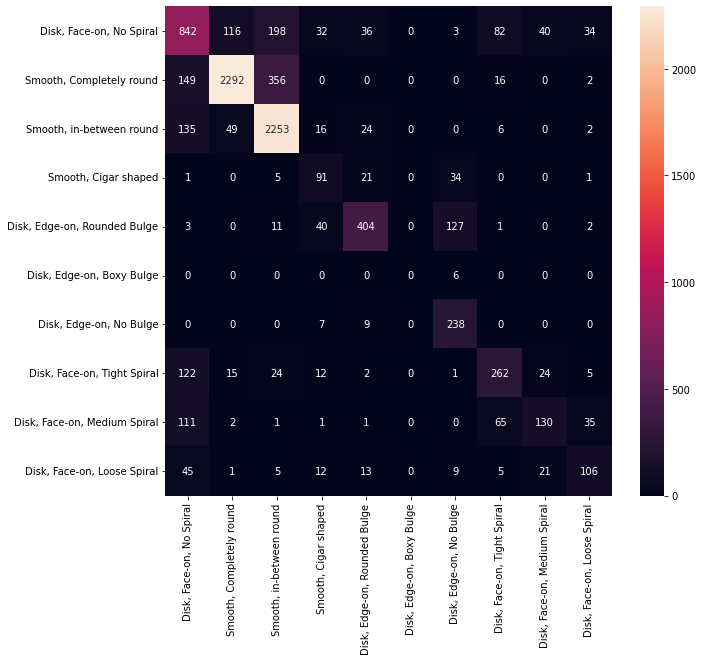

In [47]:
y_pred = cnn_classifier.predict(images_test)
show_G10_results(y_pred, y_test)

In [48]:
from sklearn.metrics import classification_report #alternative of confusion matrices to evaluate classfication because data is unbalanced and accuracy is not best metric 
print(classification_report(y_test, y_pred, labels=range(0,10), target_names=class_names, zero_division=0))

                              precision    recall  f1-score   support

    Disk, Face-on, No Spiral       0.60      0.61      0.60      1383
    Smooth, Completely round       0.93      0.81      0.87      2815
    Smooth, in-between round       0.79      0.91      0.84      2485
        Smooth, Cigar shaped       0.43      0.59      0.50       153
Disk, Edge-on, Rounded Bulge       0.79      0.69      0.74       588
   Disk, Edge-on, Boxy Bulge       0.00      0.00      0.00         6
     Disk, Edge-on, No Bulge       0.57      0.94      0.71       254
 Disk, Face-on, Tight Spiral       0.60      0.56      0.58       467
Disk, Face-on, Medium Spiral       0.60      0.38      0.46       346
 Disk, Face-on, Loose Spiral       0.57      0.49      0.52       217

                    accuracy                           0.76      8714
                   macro avg       0.59      0.60      0.58      8714
                weighted avg       0.77      0.76      0.76      8714



Using the subclass API to define the module but, since the CNN we are using is relatively simple, we will keep Sequential model defined previously. And, To work directly with PyTorch, we need to define a torch-compatible Dataset object.

In [49]:
#Since we already loaded the data in the HDF5 format, we can use the TensorDataset tool.
from torch.utils.data import TensorDataset, DataLoader

train_ds = TensorDataset(torch.from_numpy(images_train), torch.from_numpy(y_train))
test_ds = TensorDataset(torch.from_numpy(images_test), torch.from_numpy(y_test))

In [50]:
#they are iterable objects that return (sample,label) pairs
for img, label in train_ds:
    print(f"Image: {img.size()}")
    print(f"Label: {label}")
    break

Image: torch.Size([3, 69, 69])
Label: 1


In [51]:
#batch gradient descent which are job of DataLoader
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=128, shuffle=False, num_workers=0)

Defining a training function that takes a network and a DataLoader and perform the gradient descent training

In [52]:
def train(network, dataloader, epochs=10, lr=0.01, device=device):
    # Move the network to GPU if required
    network = network.to(device)
    
    # Define the optimization algorithm (here, Stochastic Gradient Descent with momentum)
    optimizer = torch.optim.SGD(network.parameters(), lr=lr, momentum=0.9)
    
    # Define the loss function (in our case, cross-entropy)
    criterion = torch.nn.CrossEntropyLoss()
    
    for e in tqdm(range(epochs), total=epochs): # One epoch = one pass on the whole dataloader
        # This puts the neural network into "training mode"
        network.train()

        # For each batch of examples, do one step of the gradient
        for batch, label in tqdm(dataloader, desc=f"Epoch {e+1}/{epochs}", leave=False):
            # Reset gradient values
            optimizer.zero_grad()
            
            # Move Tensors into CPU or GPU memory
            batch, label = batch.to(device), label.to(device)
            
            # Forward pass (get predictions from the network)
            output = network(batch)
            # Compute the error between predictions and true labels
            loss = criterion(output, label)
            # Compute the gradients (backward pass)
            loss.backward()
            
            # Update the weights (= one step of gradient descent)
            optimizer.step()
    
    return network    

In [53]:
cnn = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=(3,3), padding=1),
    nn.MaxPool2d(kernel_size=(2, 2)),
    nn.ReLU(),
    nn.Conv2d(64, 128, kernel_size=(3,3), padding=1),
    nn.MaxPool2d(kernel_size=(2, 2)),
    nn.ReLU(),
    nn.Conv2d(128, 256, kernel_size=(3,3), padding=1),
    nn.MaxPool2d(kernel_size=(2, 2)),
    nn.ReLU(),
    nn.Conv2d(256, 256, kernel_size=(3,3), padding=1),
    nn.MaxPool2d(kernel_size=(2, 2)),
    nn.ReLU(),
    nn.Conv2d(256, 256, kernel_size=(3,3), padding=1),
    nn.AdaptiveAvgPool2d((1,1)),
    nn.Flatten(),
    nn.Linear(256, 10)
)

train(cnn, train_loader, lr=0.005, epochs=50)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/103 [00:00<?, ?it/s]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (2): ReLU()
  (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (5): ReLU()
  (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (8): ReLU()
  (9): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (11): ReLU()
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): AdaptiveAvgPool2d(output_size=(1, 1))
  (14): Flatten(start_dim=1, end_dim=-1)
  (15): Linear(in_features=256, out_features=10, bias=True)
)

In [54]:
from sklearn.metrics import accuracy_score

def val(network, dataloader, device=device):
    criterion = torch.nn.CrossEntropyLoss()
    
    network = network.to(device)
    predictions = []
    labels = []
    loss = 0.
    
    with torch.no_grad():
        for batch, label in tqdm(dataloader):
            batch, label = batch.to(device), label.to(device)
            output = network(batch)
            loss += criterion(output, label)
            labels.append(label.cpu().numpy())
            predictions.append(torch.argmax(output, dim=1).cpu().numpy())
            
    print(f"Average loss: {loss/len(labels)}")
    labels, predictions = np.concatenate(labels), np.concatenate(predictions)
    print(f"Accuracy: {accuracy_score(labels, predictions)}")
    return predictions

In [55]:
val(cnn, test_loader)

  0%|          | 0/69 [00:00<?, ?it/s]

Average loss: 1.2738852500915527
Accuracy: 0.79676382832224


array([1, 1, 0, ..., 1, 1, 1])

Due to some subtleties in how skorch handles the training, this result is not directly comparable to the CNN trained with skorch. Both accuracies should however be in the same ballpark, += a few percents.

#Data Augmentation

To produce new training samples from the existing ones. For example, we know that flipping an image of a galaxy does not change the galaxy type -- we say the galaxy classification task is invariant to symetry. Therefore, for a single image, we know that its flipped and mirrored versions are acceptable images of the same class

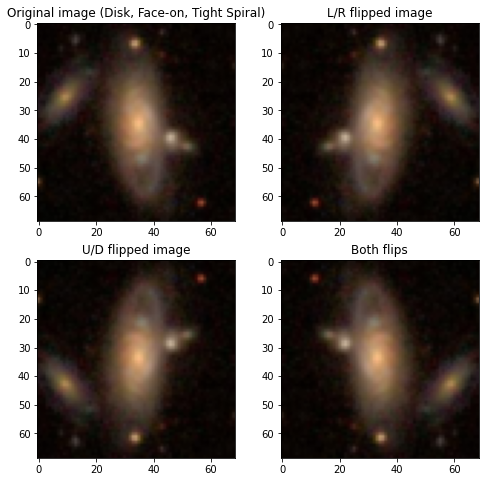

In [56]:
fig = plt.figure(figsize=(8,8))
img, l = images[9], class_names[labels[9]]
fig.add_subplot(221)
plt.imshow(img)
plt.title(f"Original image ({l})")
mirror = np.fliplr(img)
fig.add_subplot(222)
plt.imshow(mirror)
plt.title("L/R flipped image")
flip = np.flipud(img)
fig.add_subplot(223)
plt.imshow(flip)
plt.title("U/D flipped image")
both = np.fliplr(flip)
fig.add_subplot(224)
plt.imshow(both)
plt.title("Both flips")
plt.show()

In [57]:
from torch.utils.data import Dataset # since it supports __getitem__() method

class Galaxy10Dataset(Dataset):
    def __init__(self, data, targets, transform=None):
        super(Galaxy10Dataset, self).__init__()
        
        assert(len(data) == len(targets))
        self.data = data.astype('uint8')
        self.targets = targets
        self.transform = transform
    
    def __getitem__(self, index):
        
        img, target = self.data[index], self.targets[index]
        
        if self.transform is not None:
            img = 255 * self.transform(img)
        return img, target

    def __len__(self):
        return len(self.data)

We can provides some common image transformations using transform function that we can reuse. Our overall transformation is composed of four steps:

1. We convert the image array to PIL format for easier manipulation,
2. Horizontal flip the image with probability p=0.5,
3. Vertical flip the image with probability p=0.5,
4. Extract a random 64x64 crop from the image (simulate random translations),
5. Convert PIL image back to Tensor.

In [ ]:
!pip install https://github.com/CellProfiling/HPA-Cell-Segmentation/archive/master.zip 
!pip install git+https://github.com/facebookresearch/detectron2.git@v0.4 #egg=detectron2


import PIL.Image
if not hasattr(PIL.Image, 'Resampling'):  # Pillow<9.0
  PIL.Image.Resampling = PIL.Image

from torchvision import transforms

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomCrop((64, 64)),
    transforms.ToTensor()
])

In [ ]:
image = images_train[0].astype('uint8').transpose((1, 2, 0))
transformed_image = transform(image)
fig = plt.figure(figsize=(8,8))
fig.add_subplot(121)
plt.title("Original image")
plt.imshow(image)
fig.add_subplot(122)
plt.title("Transformed image")
plt.imshow(transformed_image.numpy().transpose((1, 2, 0)))
plt.show()

In [ ]:
train_augmented_ds = Galaxy10Dataset(images_train.transpose((0, 2, 3, 1)), y_train, transform=transform)
train_augmented_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=0)

By including new images corresponding to both mirroring and flipping, we virtually multiply by 3 the size of the training set which will often result in better generalization and higher accuracy.

In [ ]:
cnn = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=(3,3), padding=1),
    nn.MaxPool2d(kernel_size=(2, 2)),
    nn.ReLU(),
    nn.Conv2d(64, 128, kernel_size=(3,3), padding=1),
    nn.MaxPool2d(kernel_size=(2, 2)),
    nn.ReLU(),
    nn.Conv2d(128, 256, kernel_size=(3,3), padding=1),
    nn.MaxPool2d(kernel_size=(2, 2)),
    nn.ReLU(),
    nn.Conv2d(256, 256, kernel_size=(3,3), padding=1),
    nn.MaxPool2d(kernel_size=(2, 2)),
    nn.ReLU(),
    nn.Conv2d(256, 256, kernel_size=(3,3), padding=1),
    nn.AdaptiveAvgPool2d((1,1)),
    nn.Flatten(),
    nn.Linear(256, 10)
)

train(cnn, train_augmented_loader, lr=0.005, epochs=50)

In [62]:
y_pred = val(cnn, test_loader)

  0%|          | 0/69 [00:00<?, ?it/s]

Average loss: 2.2496752738952637
Accuracy: 0.017557952719761304


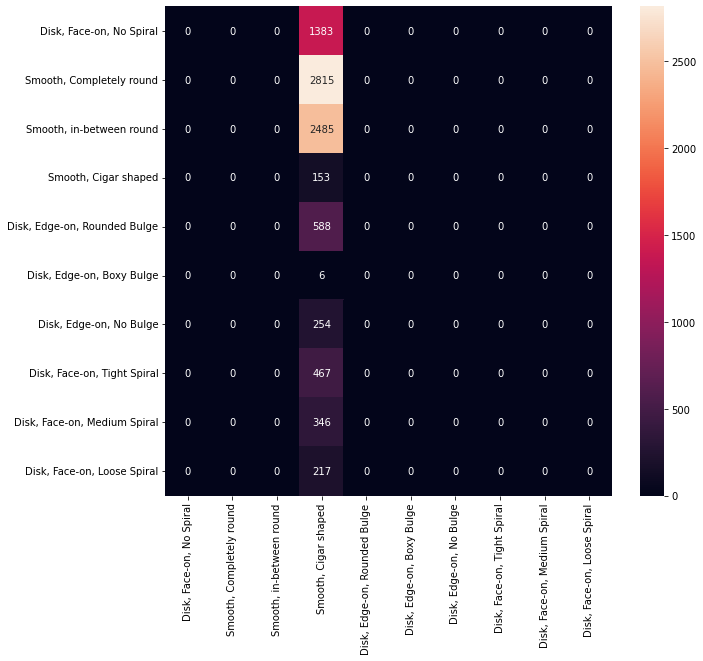

In [63]:
show_G10_results(y_pred, y_test)

used data augmentation to increase the size of your dataset

#FINE TUNING

In [64]:
from torchvision.models import resnet18, resnet34, resnet50 #to reuse the deep residual network architecture (ResNet) 

resnet = resnet18()

cnn_classifier = skorch.classifier.NeuralNetClassifier(resnet,
                                                       lr=0.01,
                                                       optimizer__momentum=0.9,
                                                       max_epochs=50,
                                                       criterion=nn.CrossEntropyLoss,
                                                       device=device)
cnn_classifier.fit(images_train, y_train)
cnn_classifier.score(images_test, y_test)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.5979       0.3717        1.8147  7.8689
      2        0.8760       0.4180        1.5839  7.9944
      3        0.7860       0.6662        0.9147  8.6320
      4        0.7126       0.7247        0.7719  8.5823
      5        0.6273       0.5901        1.1492  9.4405
      6        0.5554       0.6034        1.1075  8.2775
      7        0.4942       0.7331        0.7366  8.0708
      8        0.4634       0.4811        1.6299  7.9795
      9        0.4235       0.2073        4.1144  7.9638
     10        0.3941       0.2654        3.8479  7.9368
     11        0.3857       0.3143        3.1311  7.9650
     12        0.3804       0.6421        1.0203  7.9864
     13        0.3128       0.7488        0.8444  8.0543
     14        0.2656       0.7270        1.3570  8.1192
     15        0.2352       0.6922        1.7972  8.1250
     16        0.2276       0.7

0.7845994950654119

The models trained on ImageNet cannot be directly used for galaxy classification.However, can fine-tuning to leverage what the model has learnt for generic image classification on ImageNet and specialize it on the Galaxy10 dataset.

In [65]:
from torchvision.models import resnet18, resnet34, resnet50

# pretrained=True will load the model with weights obtained by training on ImageNet
resnet = resnet18(pretrained=True)

cnn_classifier = skorch.classifier.NeuralNetClassifier(resnet,
                                                       lr=1e-4, # lower learning rate
                                                       optimizer__momentum=0.99,
                                                       max_epochs=10, # only 10 epochs instead of 50
                                                       criterion=nn.CrossEntropyLoss,
                                                       device=device)
cnn_classifier.fit(images_train, y_train)
cnn_classifier.score(images_test, y_test)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        5.4114       0.5813        1.6780  7.9724
      2        1.0618       0.6635        0.9003  8.0229
      3        0.7086       0.7446        0.7113  7.9595
      4        0.5759       0.7774        0.6507  7.9416
      5        0.4874       0.7889        0.6167  7.9728
      6        0.4179       0.7920        0.5925  7.9603
      7        0.3636       0.7633        0.6345  7.9675
      8        0.3175       0.7468        0.6734  7.9652
      9        0.2739       0.7507        0.6979  7.9655
     10        0.2319       0.7205        0.8452  8.0069


0.7396144135873307

Reached a similar accuracy but in less epochs. The pretrained weights gave this model a head start for training.

Using SOTA pretrained models (available online) to leverage large models even with limited computational power.

In [66]:
from torchvision.models import densenet121

# pretrained=True will load the model with weights obtained by training on ImageNet
densenet = densenet121(pretrained=True)

cnn_classifier = skorch.classifier.NeuralNetClassifier(densenet,
                                                       lr=1e-4, # lower learning rate
                                                       optimizer__momentum=0.99,
                                                       max_epochs=6, # only 6 epochs
                                                       criterion=nn.CrossEntropyLoss,
                                                       device=device)
cnn_classifier.fit(images_train, y_train)
cnn_classifier.score(images_test, y_test)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        5.7425       0.5962        1.7188  15.6695
      2        0.9978       0.7163        0.8452  15.7472
      3        0.6576       0.7644        0.6557  15.6689
      4        0.5460       0.7954        0.5686  15.6987
      5        0.4613       0.7973        0.5466  15.6743
      6        0.3913       0.8149        0.5119  15.6775


0.8197154005049346

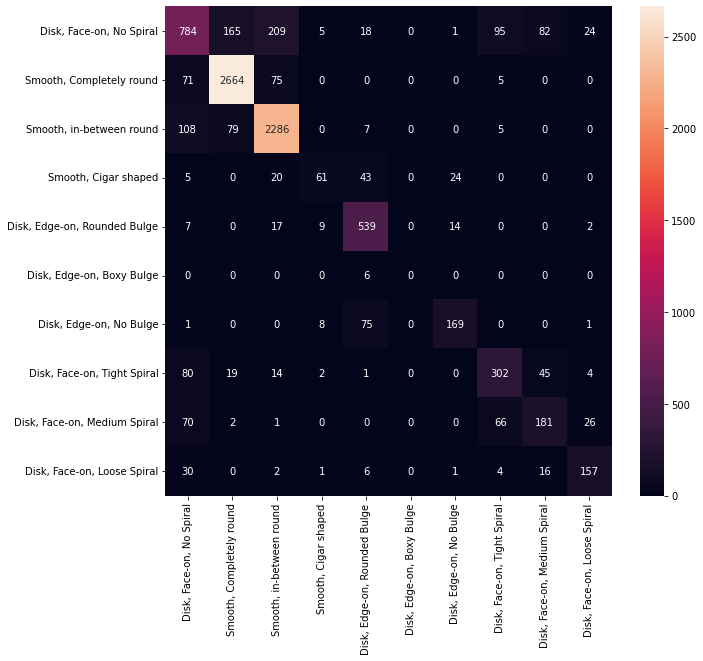

In [67]:
show_G10_results(cnn_classifier.predict(images_test), y_test)

Playing with deep features

Demonstrate how to extract intermediate activations (features) from the CNN trained on Galaxy10 to use for image retrieval and 2D visualization.

In [68]:
#helper function
feat_extractor = nn.Sequential(*list(cnn_classifier.module.children())[0][:-1])

def extract_features(network, dataset, batch_size=128, transpose=True, device='cpu'):
    bs = batch_size
    network = network.to(device)
    features = np.zeros((len(dataset), 1024), dtype='float32')
    with torch.no_grad():
        for idx in tqdm(range(len(dataset) // bs)):
            data = dataset[idx*bs:idx*bs+bs]
            if transpose:
                data = data.transpose((0, 3, 1, 2))
            batch = torch.from_numpy(data).to(device)
            features[idx*bs:idx*bs+bs] = network(batch).cpu().numpy().mean(axis=(2,3))
    return features

train_features = extract_features(feat_extractor, images_train, transpose=False, device=device)
test_features = extract_features(feat_extractor, images_test, transpose=False, device=device)

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/68 [00:00<?, ?it/s]

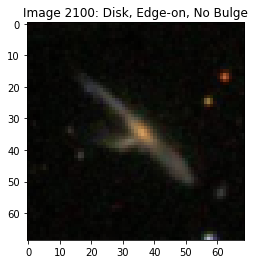

In [69]:
#for each image we have 1024-vector that describes it.

i = 2100
plt.imshow(images_test[i].transpose((1, 2, 0)).astype('uint8'))
plt.title(f"Image {i}: {class_names[y_test[i]]}")
plt.show()

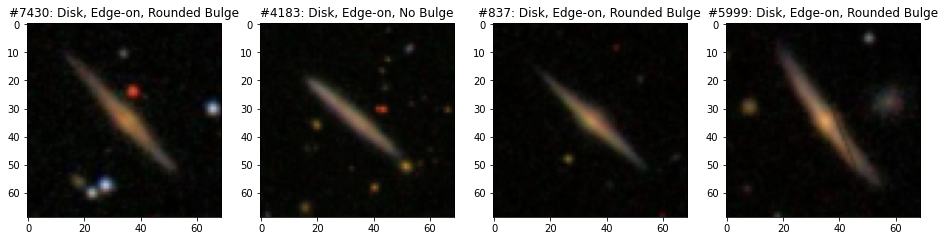

In [70]:
# Finding out 4 nearest neighbours of this image
def find_closest_image(query, features):
    distances = [np.linalg.norm(query - f) for f in features]
    return np.argsort(distances)

nearest = find_closest_image(test_features[i], test_features)
fig = plt.figure(figsize=(16, 8))
for idx, i in enumerate(nearest[1:5]):
    fig.add_subplot(1,4,idx+1)
    plt.imshow(images_test[i].transpose((1, 2, 0)).astype('uint8'))
    plt.title(f"#{i}: {class_names[y_test[i]]}")
plt.show()

This function can be very useful to detect near-duplicates or to find images that look like other things.

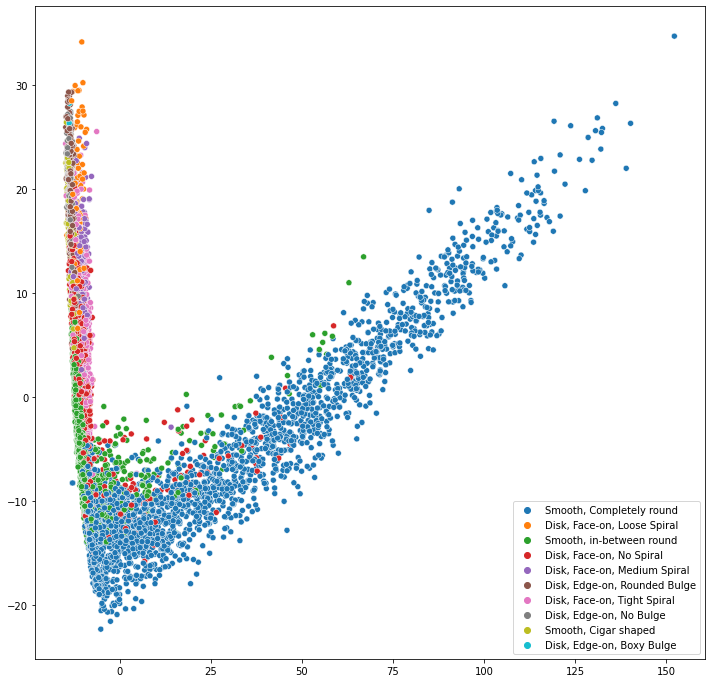

In [71]:
#project our deep feature vectors in a 2D space so that we can visualize our data using a point cloud
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

pipeline = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=2))])
X = pipeline.fit_transform(test_features)
fig = plt.figure(figsize=(12, 12))
sns.scatterplot(x=X[:,0], y=X[:, 1], hue=np.array([class_names[y] for y in y_test]))
plt.show()

We have seen some types of galaxies have been clustered around the same point while others are strangely quite far from other supposedly similar images. Maybe these images are outliers because of sensor noise/artifacts or because the objects are weird.

However, PCA is not very effective on deep features because the activations are probably not linearly correlated.

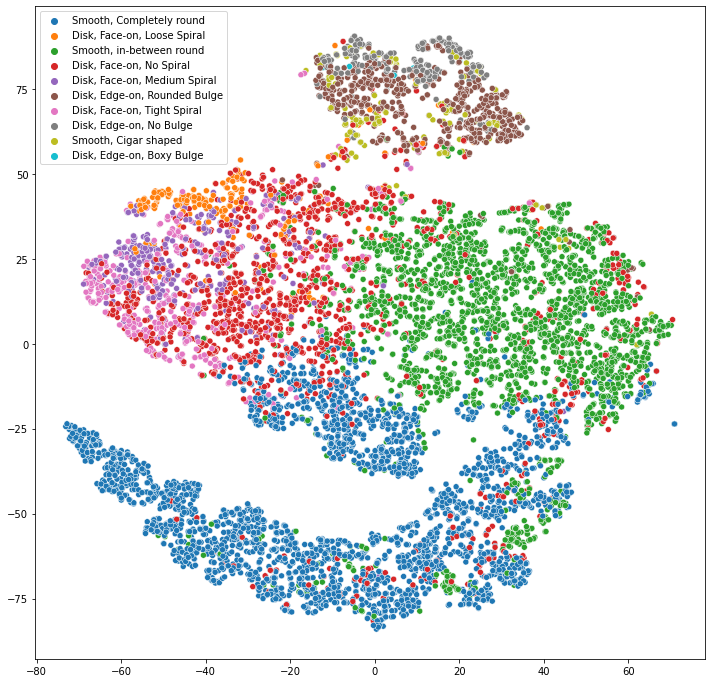

In [72]:
from sklearn.manifold import TSNE #alternative of PCA as t-SNE and UMAP 

tsne = TSNE(n_components=2, perplexity=30.0, n_jobs=4)
X = tsne.fit_transform(test_features)
fig = plt.figure(figsize=(12, 12))
sns.scatterplot(x=X[:,0], y=X[:, 1], hue=np.array([class_names[y] for y in y_test]))
plt.show()

Taking an idea of the underlying topology of the data: which images are close to others and Are some classes mixed and difficult to separate. This is consistent with the confusion matrix and can help us "debug" the errors committed by the network.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 7.1 MB/s 
     |████████████████████████████████| 1.1 MB 65.0 MB/s 
     |████████████████████████████████| 18.2 MB 969 kB/s 
     |████████████████████████████████| 76 kB 6.4 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=f277f93b669ac6e9f258c0e69a49a4d4b879ad2e50c9b3fbe12fb53f96d665db
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=46aa8831470a1a69b57f3e09d222324a28a727d0f88b1e8995fcc7024f82c260
  Stored in directory: /root/.cache/pip/wheels/7f/2a/f8/7bd5dcec71bd5c669f6f574db3113513696b98f3f9b51f496c
  Created wheel for datashape: filename=datashape-0.5.2-py3-none-any.whl size=59438 sha256=c9e6d0b47ab981300f020e6b01d1f2f3461ee10e3cad6101f0

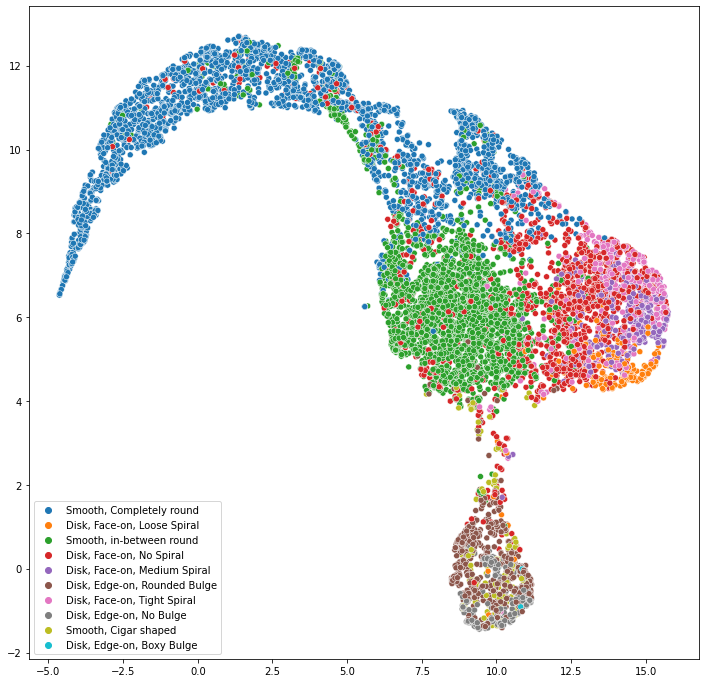

In [73]:
!pip install umap-learn[plot]
!pip install holoviews
!pip install -U ipykernel
from umap import UMAP #using UMAP as shapes differ but relative positions of classes should stay somewhat the same

um = UMAP(n_components=2, n_neighbors=15, min_dist=0.1)
X = um.fit_transform(test_features)
fig = plt.figure(figsize=(12, 12))
sns.scatterplot(x=X[:,0], y=X[:, 1], hue=np.array([class_names[y] for y in y_test]))#, palette=plt.cm.tab10)
plt.show()

#Subclassing API

Sequential API to define neural networks that are topologically simple. But to have full control on the neural network architecture we use subclassing API consists in torch.nn.Module base class. Here we need backward pass to define custom networks and custom layers.

In [ ]:
import torch.nn.functional as F

class G10CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(G10CNN, self).__init__ # create the core of the module
        self.conv1 = nn.Conv2d(3, 64, kernel_size=(3,3), padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3,3), padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3,3), padding=1)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=(3,3), padding=1),
        self.conv5 = nn.Conv2d(256, 256, kernel_size=(3,3), padding=1)
        # Since Maxpooling has no parameters, we define it only once
        self.maxpool = nn.MaxPool2d(kernel_size=(2, 2))
    
        
        # We can also combine modules
        self.classifier = nn.Sequential(nn.AdaptiveAvgPool2d((1,1)),
                                        nn.Flatten(),
                                        nn.Linear(256, num_classes))
    
    def forward(self, x):
        # This defines the forward pass
        # We apply all layers in succession but we create a more complex graph
        x = self.conv1(x)
        # We can apply ReLU as a function instead of defining a layer
        x = F.relu(self.maxpool(x))
        x = self.conv2(x)
        x = F.relu(self.maxpool(x))
        x = self.conv3(x)
        x = F.relu(self.maxpool(x))
        x = self.conv4(x)
        x = F.relu(self.maxpool(x))
        x = self.conv5(x)
        # Final classification (Average Pooling + Flatten + linear classifier)
        x = self.classifier(x)
        return x

subclassed_cnn = G10CNN(num_classes=10)

Data processing in a sequence of several estimators (for example standardization + dimension reduction + clustering) can be error prone. Another mistake consists in using test data to fit an estimator by mistake.

In [75]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=2)), ('tree', DecisionTreeClassifier())])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.3904062428276337

feature extraction: Instead of designing expert features such as HOGs, you can use a pretrained deep neural network from the state-of-the-art, apply it on your data and use the activations from the last layer as a feature vector. This leverages the powerful pretrained model that has learnt on a very large dataset what images look like.

In [76]:
import torch

from torch import nn

from tqdm import trange
from torchvision.models import densenet121

feature_net = nn.Sequential(*densenet121(pretrained=True).features[:-1])

features_train = extract_features(feature_net, images_train, transpose=False)

  0%|          | 0/102 [00:00<?, ?it/s]

In [77]:
features_train.shape

(13071, 1024)

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(features_train)

#, 'kernel': ['linear', 'rbf'], 'gamma': ['auto', 'scale']
grid = {'C': [1e-2, 0.1, 1.0, 10, 100, 1000, 10000]}
model = GridSearchCV(LinearSVC(), grid, verbose=1, n_jobs=6)
model.fit(features_train, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


In [80]:
features_test = extract_features(feature_net, images_test, transpose=False)

  0%|          | 0/68 [00:00<?, ?it/s]

In [ ]:
svm.score(scaler.transform(features_test), y_test)

In this case the off-the-shelf deep features do not perform very well, maybe because the semantic gap between ImageNet and Galaxy10 is too large.